In [616]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from os.path import expanduser as ospath
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
import seaborn as sns
from sklearn import preprocessing
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *

import warnings
warnings.filterwarnings('ignore')
# IterativeImputer is a regression imputing algorithm
# KNNImputer finds closest looking rows and imputes the mean of it

In [608]:
'''
Data Pre-processing
'''
# Read csv
df = pd.read_csv('Penrose_Hourly AggregateData_Jan2016Dec2020.csv',delimiter=',',encoding='unicode_escape')
print(df)
# Change column names to easier to call
columns = ['time','temp','humidity','radiation','wind_direction','wind_speed','NO','NO2','SO2','PM2.5','PM2.5_Lag1','PM2.5_Lag2']
df.columns = columns
# Change the time column to datetime format
df["time"] = pd.to_datetime(df["time"])
df.describe()

      Timestamp (UTC+12:00)  Air Temp (°C)  Relative Humidity (%)  \
0            1/01/2016 0:00        19.0000                70.1000   
1            1/01/2016 1:00        19.0000                72.1000   
2            1/01/2016 2:00        19.0000                70.2000   
3            1/01/2016 3:00        19.0000                70.2000   
4            1/01/2016 4:00        19.0000                69.6000   
...                     ...            ...                    ...   
37176      31/12/2020 19:00        21.0000                61.2000   
37177      31/12/2020 20:00        20.0000                65.0000   
37178      31/12/2020 21:00        19.0000                67.1000   
37179      31/12/2020 22:00        19.0000                69.6000   
37180      31/12/2020 23:00        18.0000                71.6000   

       Solar Radiation (W/m²)  Wind Direction (°)  Wind Speed (m/s)  \
0                      0.5000             68.0000            4.0000   
1                      0.7000

,temp,humidity,radiation,wind_direction,wind_speed,NO,NO2,SO2,PM2.5,PM2.5_Lag1,PM2.5_Lag2
count,36860.0000,36610.0000,12958.0000,35730.0000,36804.0000,33544.0000,33713.0000,31846.0000,25168.0000,25168.0000,25168.0000
mean,16.0630,71.8147,165.3646,190.6777,2.7005,14.2973,17.7728,1.1077,6.5179,6.5181,6.5181
std,3.8998,12.6985,251.2773,90.1002,1.5676,27.3654,14.3077,1.7787,5.0597,5.0597,5.0597
min,2.0000,26.9000,0.0000,2.0000,0.1000,-1.3000,-3.9000,-2.8000,-12.3000,-12.3000,-12.3000
25%,13.0000,62.3000,0.4000,124.0000,1.4000,1.5000,6.4000,0.2000,3.6000,3.6000,3.6000
50%,16.0000,72.6000,6.1000,219.0000,2.5000,5.7000,14.0000,0.7000,5.8000,5.8000,5.8000
75%,19.0000,82.0000,270.3750,244.0000,3.7000,15.7000,26.1000,1.3000,8.5000,8.5000,8.5000
max,28.0000,99.6000,1078.5000,358.0000,10.5000,467.0000,98.4000,26.6000,96.8000,96.8000,96.8000


In [117]:
'''
We can see that there is no obvious abnormality in the temp, humidity, radiation, wind_direction and wind_speed columns.
However NO, NO2, SO2, PM2.5, PM2.5_Lag1, PM2.5_Lag2 columns have negative values, which is not logically correct. We cannot have
negative values for concentration. This occurs sometimes when the device is not calibrated for a while. 
'''
# Check the number of nulls in each columns
df.isnull().sum()

time                  0
temp                321
humidity            571
radiation         24223
wind_direction     1451
wind_speed          377
NO                 3637
NO2                3468
SO2                5335
PM2.5             12013
PM2.5_Lag1        12013
PM2.5_Lag2        12013
dtype: int64

In [118]:
# Check that data input are hourly
test = df['time'].diff()
print(test.value_counts())

0 days 01:00:00        36479
30 days 01:00:00         304
29 days 01:00:00         206
0 days 02:00:00           30
27 days 01:00:00          27
28 days 01:00:00          24
-236 days +01:00:00        7
-88 days +01:00:00         6
-177 days +01:00:00        5
-266 days +01:00:00        5
-207 days +01:00:00        5
-323 days +01:00:00        4
-29 days +01:00:00         4
-59 days +01:00:00         4
-118 days +01:00:00        4
-294 days +01:00:00        4
-30 days +01:00:00         4
-324 days +01:00:00        4
-148 days +01:00:00        3
0 days 04:00:00            3
0 days 03:00:00            3
-116 days +01:00:00        3
-147 days +01:00:00        2
-57 days +01:00:00         2
-264 days +01:00:00        2
-175 days +01:00:00        2
-146 days +01:00:00        2
-87 days +01:00:00         2
-293 days +01:00:00        2
-176 days +01:00:00        2
-58 days +01:00:00         2
-295 days +01:00:00        2
-117 days +01:00:00        2
-265 days +01:00:00        2
-235 days +01:

array([[<AxesSubplot:title={'center':'time'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'humidity'}>],
       [<AxesSubplot:title={'center':'radiation'}>,
        <AxesSubplot:title={'center':'wind_direction'}>,
        <AxesSubplot:title={'center':'wind_speed'}>],
       [<AxesSubplot:title={'center':'NO'}>,
        <AxesSubplot:title={'center':'NO2'}>,
        <AxesSubplot:title={'center':'SO2'}>],
       [<AxesSubplot:title={'center':'PM2.5'}>,
        <AxesSubplot:title={'center':'PM2.5_Lag1'}>,
        <AxesSubplot:title={'center':'PM2.5_Lag2'}>]], dtype=object)

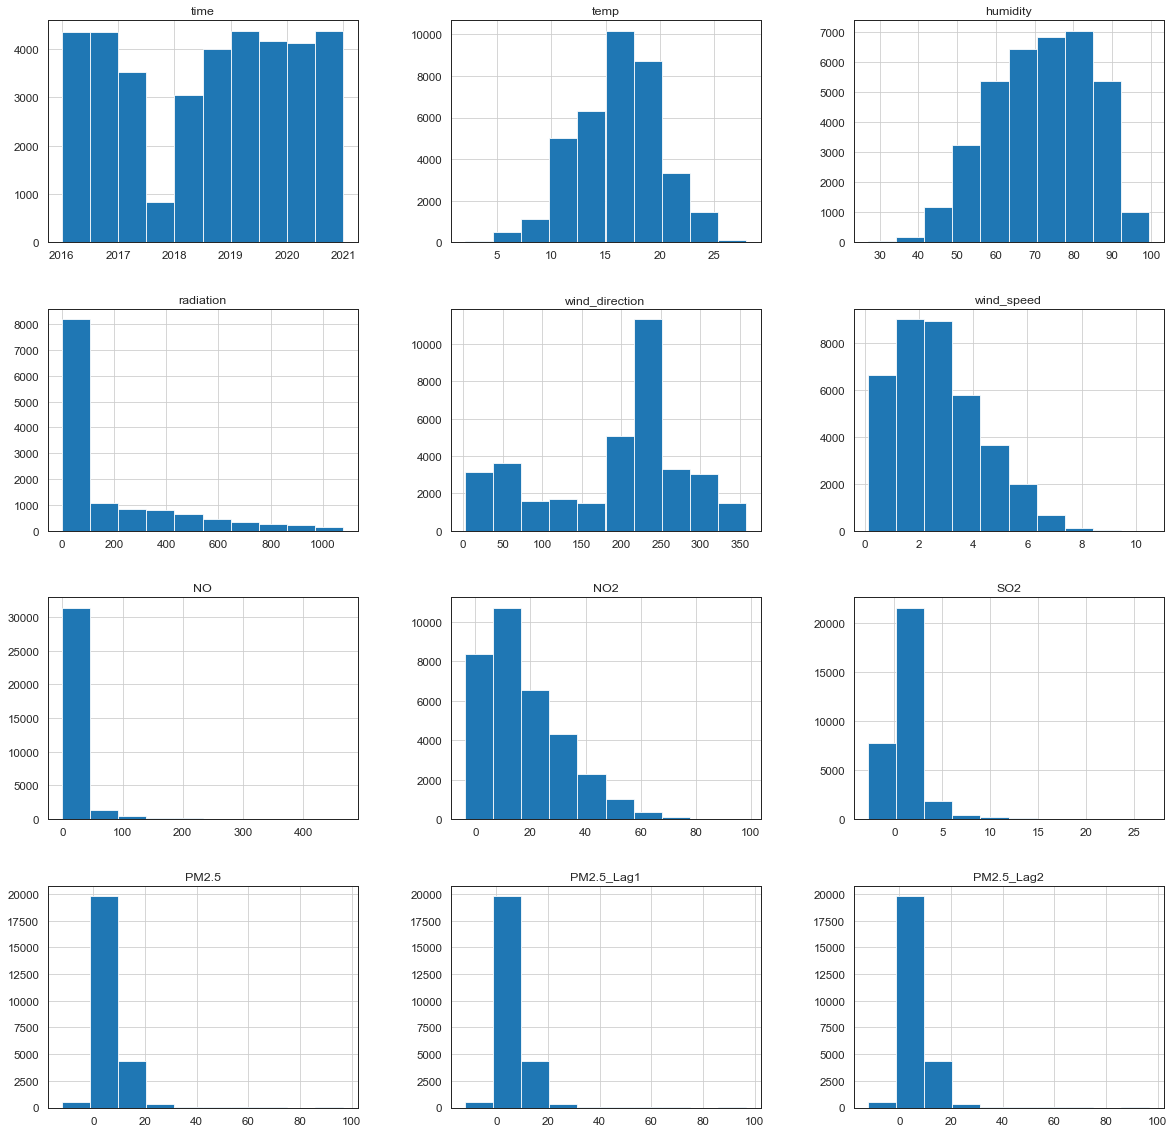

In [529]:
#Check data with historgram
df.hist(figsize = (20,20))

In [609]:
# We observe negative values suggesting that some lines are not in order
# Sort values in order
df = df.sort_values(by='time')
test2 = df['time'].diff()
print(test2.value_counts())

0 days 01:00:00     37105
0 days 02:00:00        32
6 days 01:00:00         6
2 days 01:00:00         4
3 days 01:00:00         4
25 days 01:00:00        3
0 days 04:00:00         3
0 days 03:00:00         3
24 days 01:00:00        2
0 days 17:00:00         2
0 days 13:00:00         1
0 days 19:00:00         1
1 days 01:00:00         1
3 days 02:00:00         1
2 days 17:00:00         1
0 days 16:00:00         1
0 days 05:00:00         1
2 days 21:00:00         1
2 days 10:00:00         1
0 days 21:00:00         1
19 days 01:00:00        1
22 days 01:00:00        1
28 days 01:00:00        1
0 days 12:00:00         1
0 days 14:00:00         1
10 days 18:00:00        1
Name: time, dtype: int64


In [610]:
# There are also missing time points that miss an entry as a whole
# Add rows to fill these times
df = (df.set_index('time').resample('H').asfreq())
# Check the number of nulls in each columns
df.isnull().sum()

temp               6988
humidity           7238
radiation         30890
wind_direction     8118
wind_speed         7044
NO                10304
NO2               10135
SO2               12002
PM2.5             18680
PM2.5_Lag1        18680
PM2.5_Lag2        18680
dtype: int64

In [121]:
df

,temp,humidity,radiation,wind_direction,wind_speed,NO,NO2,SO2,PM2.5,PM2.5_Lag1,PM2.5_Lag2
time,,,,,,,,,,,
2016-01-01 00:00:00,19.0,70.1,0.5,68.0,4.0,0.7,0.7,0.5,12.0,9.7,7.7
2016-01-01 01:00:00,19.0,72.1,0.7,72.0,3.7,0.5,1.1,0.3,21.0,12.0,9.7
2016-01-01 02:00:00,19.0,70.2,0.8,72.0,4.4,0.7,0.5,0.3,17.8,21.0,12.0
2016-01-01 03:00:00,19.0,70.2,0.7,72.0,3.8,NaN,NaN,0.4,10.6,17.8,21.0
2016-01-01 04:00:00,19.0,69.6,1.1,71.0,3.9,0.3,0.4,0.0,8.9,10.6,17.8
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,21.0,61.2,NaN,341.0,2.2,NaN,NaN,0.0,4.1,2.6,4.9
2020-12-31 20:00:00,20.0,65.0,NaN,245.0,2.1,NaN,NaN,0.0,8.4,4.1,2.6
2020-12-31 21:00:00,19.0,67.1,NaN,213.0,2.0,NaN,NaN,0.0,5.7,8.4,4.1


In [611]:
#Remove outliers
Q1 = df.quantile(0.05)
Q2 = df.quantile(0.95)
IQR = Q2 - Q1

df2 = df[~((df.iloc[:,1:] < (Q1 - 1.5 * IQR)) |(df.iloc[:,1:] > (Q2 + 1.5 * IQR))).any(axis=1)]

df2.shape
df2

,temp,humidity,radiation,wind_direction,wind_speed,NO,NO2,SO2,PM2.5,PM2.5_Lag1,PM2.5_Lag2
time,,,,,,,,,,,
2016-01-01 00:00:00,19.0000,70.1000,0.5000,68.0000,4.0000,0.7000,0.7000,0.5000,12.0000,9.7000,7.7000
2016-01-01 01:00:00,19.0000,72.1000,0.7000,72.0000,3.7000,0.5000,1.1000,0.3000,21.0000,12.0000,9.7000
2016-01-01 02:00:00,19.0000,70.2000,0.8000,72.0000,4.4000,0.7000,0.5000,0.3000,17.8000,21.0000,12.0000
2016-01-01 03:00:00,19.0000,70.2000,0.7000,72.0000,3.8000,NaN,NaN,0.4000,10.6000,17.8000,21.0000
2016-01-01 04:00:00,19.0000,69.6000,1.1000,71.0000,3.9000,0.3000,0.4000,0.0000,8.9000,10.6000,17.8000
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,21.0000,61.2000,NaN,341.0000,2.2000,NaN,NaN,0.0000,4.1000,2.6000,4.9000
2020-12-31 20:00:00,20.0000,65.0000,NaN,245.0000,2.1000,NaN,NaN,0.0000,8.4000,4.1000,2.6000
2020-12-31 21:00:00,19.0000,67.1000,NaN,213.0000,2.0000,NaN,NaN,0.0000,5.7000,8.4000,4.1000


In [612]:
# Now we can impute the nulls to complete the dataset
df3 = df2

#Iterative Imputing
impute_it = IterativeImputer()
df3.loc[:,:] = impute_it.fit_transform(df3.loc[:,:])

print(df3)

                       temp  humidity  radiation  wind_direction  wind_speed  \
time                                                                           
2016-01-01 00:00:00 19.0000   70.1000     0.5000         68.0000      4.0000   
2016-01-01 01:00:00 19.0000   72.1000     0.7000         72.0000      3.7000   
2016-01-01 02:00:00 19.0000   70.2000     0.8000         72.0000      4.4000   
2016-01-01 03:00:00 19.0000   70.2000     0.7000         72.0000      3.8000   
2016-01-01 04:00:00 19.0000   69.6000     1.1000         71.0000      3.9000   
...                     ...       ...        ...             ...         ...   
2020-12-31 19:00:00 21.0000   61.2000   297.9782        341.0000      2.2000   
2020-12-31 20:00:00 20.0000   65.0000   239.5114        245.0000      2.1000   
2020-12-31 21:00:00 19.0000   67.1000   214.1479        213.0000      2.0000   
2020-12-31 22:00:00 19.0000   69.6000   174.8090        197.0000      1.0000   
2020-12-31 23:00:00 18.0000   71.6000   

In [613]:
# We can see negative values where we should not have them still.
# Change any value < 0 to 0
df3 = df3.clip(lower=0)

In [614]:
# Wind speed and direction will work better for the algorithm as a wind vector
wv = df3.pop('wind_speed')

# Convert to radians.
wd_rad = df3.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components.
df3['Wx'] = wv*np.cos(wd_rad)
df3['Wy'] = wv*np.sin(wd_rad)


In [126]:
# Check if all nulls have been eliminated successfully
# Last check before scaling
df3.isnull().sum()

temp          0
humidity      0
radiation     0
NO            0
NO2           0
SO2           0
PM2.5         0
PM2.5_Lag1    0
PM2.5_Lag2    0
Wx            0
Wy            0
dtype: int64

In [127]:
# Check data
# Last check before scaling
df3.describe()

,temp,humidity,radiation,NO,NO2,SO2,PM2.5,PM2.5_Lag1,PM2.5_Lag2,Wx,Wy
count,43308.000000,43308.000000,43308.000000,43308.000000,43308.000000,43308.000000,43308.000000,43308.000000,43308.000000,43308.000000,43308.000000
mean,16.140369,71.702599,182.696907,12.088749,17.319024,0.982213,6.341052,6.329564,6.346475,-0.987728,-0.841335
std,3.513565,11.543448,184.200990,16.531948,12.456281,1.111615,3.455299,3.473715,3.514687,2.076472,1.865720
min,2.000000,29.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.499823,-9.093267
25%,14.000000,64.300000,5.500000,2.000000,7.900000,0.300000,4.663848,4.700000,4.700000,-2.680844,-2.068320
50%,16.140369,71.702599,175.506379,8.300000,17.314516,0.808604,6.297615,6.286070,6.303114,-1.190953,-0.528758
75%,18.000000,79.900000,267.276061,12.600000,22.600000,1.100000,7.300000,7.200000,7.200000,0.478828,0.255958
max,28.000000,99.600000,1078.500000,139.100000,98.400000,10.500000,37.300000,37.100000,37.100000,7.840857,5.983282


In [809]:
# Scale the data
mlp_df = df3
scal = StandardScaler()
scale = scal.fit_transform(mlp_df)
scale = pd.DataFrame(scale,columns=['temp',
                                    'humidity',
                                    'radiation',
                                    'NO',
                                    'NO2',
                                    'SO2',
                                    'PM2.5',
                                    'PM2.5_Lag1',
                                    'PM2.5_Lag2',
                                    'Wx',
                                    'Wy'])

In [156]:
# check scale
scale

,temp,humidity,radiation,NO,NO2,SO2,PM2.5,PM2.5_Lag1,PM2.5_Lag2,Wx,Wy
0,0.813892,-0.138834,-0.989132,-0.688901,-1.334204,-0.433800,1.637778,0.970280,0.385110,1.197311,2.438803
1,0.813892,0.034427,-0.988046,-0.700999,-1.302091,-0.613720,4.242503,1.632403,0.954157,1.026316,2.337058
2,0.813892,-0.130171,-0.987503,-0.688901,-1.350260,-0.613720,3.316379,4.223319,1.608561,1.130490,2.693889
3,0.813892,-0.130171,-0.988046,-0.410583,-0.649996,-0.523760,1.232599,3.302104,4.169274,1.041198,2.388034
4,0.813892,-0.182149,-0.985874,-0.713097,-1.358288,-0.883601,0.740595,1.229371,3.258799,1.087166,2.427433
...,...,...,...,...,...,...,...,...,...,...,...
43303,1.383121,-0.909843,0.625853,-0.683721,-0.284693,-0.883601,-0.648592,-1.073665,-0.411556,1.477460,0.067045
43304,1.098507,-0.580648,0.308441,-0.537811,-0.169592,-0.883601,0.595888,-0.641846,-1.065961,0.048270,-0.569176
43305,0.813892,-0.398724,0.170745,-0.585855,-0.260507,-0.883601,-0.185529,0.596036,-0.639175,-0.332112,-0.132896
43306,0.813892,-0.182149,-0.042823,-0.530410,-0.137651,-0.883601,0.132826,-0.181239,0.584276,0.015133,0.294240


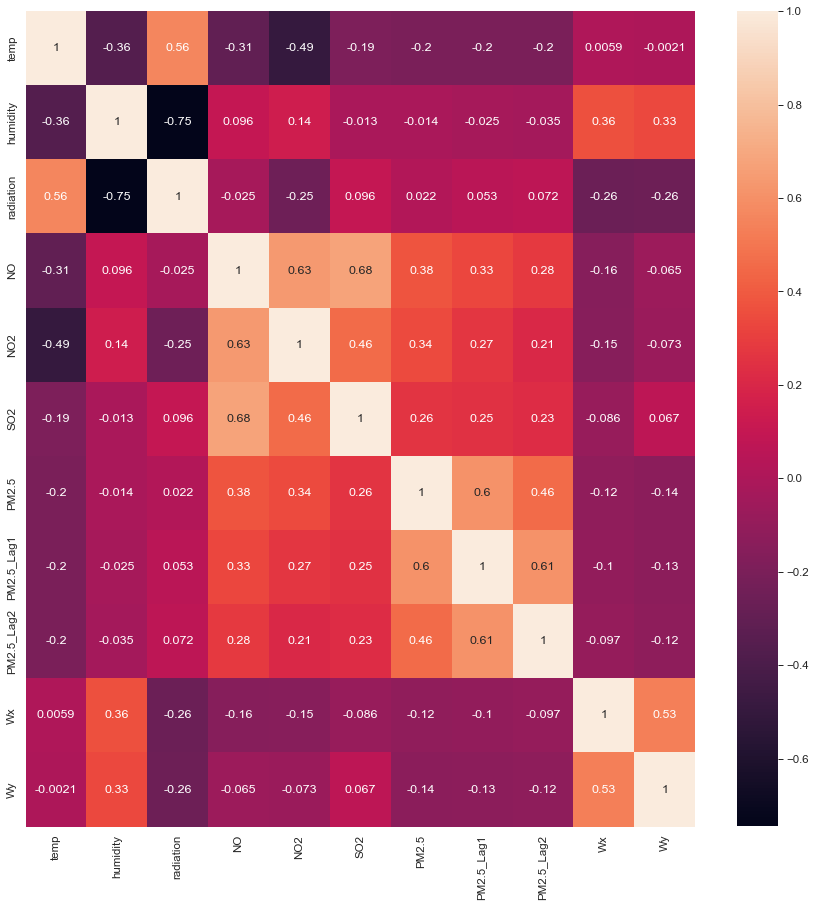

PM2.5        1.0000
PM2.5_Lag1   0.6047
PM2.5_Lag2   0.4581
NO           0.3796
NO2          0.3397
SO2          0.2571
temp         0.2041
Wy           0.1368
Name: PM2.5, dtype: float64


In [810]:
'''
Feature Selection
'''
# Correlation matrix
correlation = scale.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, annot=True)
plt.show()
# top 6 values of the correlation values (including 'Class/ASD' itself)
corr_value = abs(correlation['PM2.5'])
print(corr_value.sort_values(ascending=False).head(8))

In [811]:
# Take PM2.5 and top 5 columns
mlp_df = scale[['PM2.5','PM2.5_Lag1','PM2.5_Lag2','NO','NO2','SO2']]
# Convert to dataframe
data = pd.DataFrame(data=mlp_df,columns=['PM2.5','PM2.5_Lag1','PM2.5_Lag2','NO','NO2','SO2'])
# Check data
print(data)

        PM2.5  PM2.5_Lag1  PM2.5_Lag2      NO     NO2     SO2
0      1.6378      0.9703      0.3851 -0.6889 -1.3342 -0.4338
1      4.2425      1.6324      0.9542 -0.7010 -1.3021 -0.6137
2      3.3164      4.2233      1.6086 -0.6889 -1.3503 -0.6137
3      1.2326      3.3021      4.1693 -0.4106 -0.6500 -0.5238
4      0.7406      1.2294      3.2588 -0.7131 -1.3583 -0.8836
...       ...         ...         ...     ...     ...     ...
43303 -0.6486     -1.0737     -0.4116 -0.6837 -0.2847 -0.8836
43304  0.5959     -0.6418     -1.0660 -0.5378 -0.1696 -0.8836
43305 -0.1855      0.5960     -0.6392 -0.5859 -0.2605 -0.8836
43306  0.1328     -0.1812      0.5843 -0.5304 -0.1377 -0.8836
43307 -0.3013      0.1354     -0.1839 -0.5838 -0.1152 -0.8836

[43308 rows x 6 columns]


In [525]:
# Print the summary statistics
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM2.5,43308.0000,-0.0000,1.0000,-1.8352,-0.4854,-0.0126,0.2775,8.9599
PM2.5_Lag1,43308.0000,0.0000,1.0000,-1.8222,-0.4691,-0.0125,0.2506,8.8582
PM2.5_Lag2,43308.0000,0.0000,1.0000,-1.8057,-0.4685,-0.0123,0.2428,8.7501
NO,43308.0000,0.0000,1.0000,-0.7312,-0.6103,-0.2292,0.0309,7.6829
NO2,43308.0000,-0.0000,1.0000,-1.3904,-0.7562,-0.0004,0.4240,6.5093
SO2,43308.0000,0.0000,1.0000,-0.8836,-0.6137,-0.1562,0.1060,8.5622


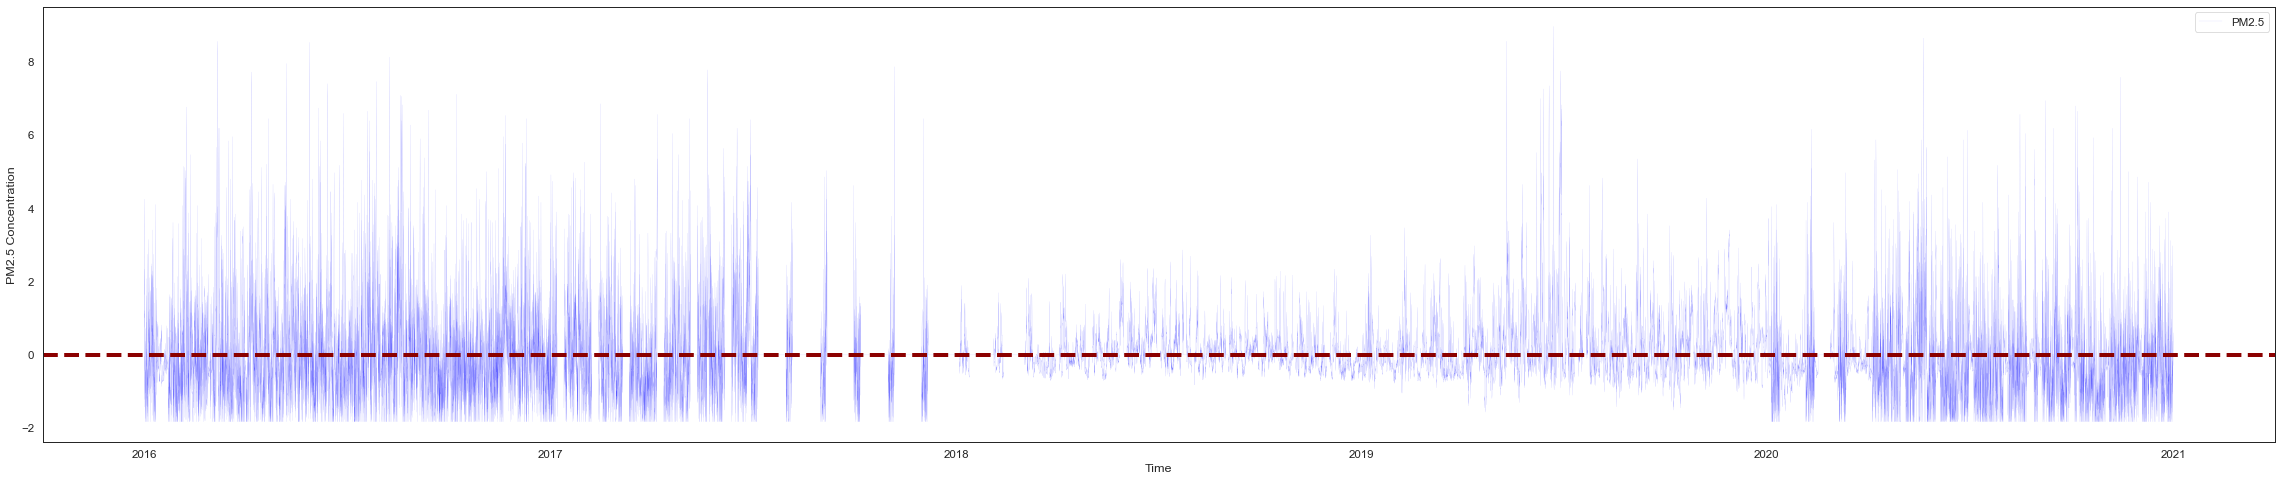

In [812]:
# Plot the PM2.5 Variation
df_mean = data["PM2.5"].mean()
plt.figure(figsize=(40,8))
plt.plot(df3.index, data['PM2.5'], color = 'blue', label = 'PM2.5', linewidth = 0.05)
plt.axhline(y=df_mean, color='darkred', linestyle='--', linewidth = 4)
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()

In [813]:
# Assign y and X values for fitting the model
y = data['PM2.5']
X = data[['PM2.5_Lag1','PM2.5_Lag2','NO','NO2','SO2']]
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

In [814]:
'''
Multilayer Perceptron (MLP)
'''
# Question 2
# MLP training
mlp = MLPRegressor(hidden_layer_sizes=(25,), max_iter=10000, random_state=177).fit(X_train,y_train)
mlp.fit(X_train,y_train)
expected_y = y_test
predicted_y = mlp.predict(X_test)
print(mlp.n_iter_) #Showing the number of iterations the solevr has run to get the accuracies below

# Scoring
MSE = mean_squared_error(expected_y, predicted_y)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(expected_y, predicted_y)
print("RMSE score is", RMSE)
print("The R2 score is", r2_score(expected_y, predicted_y ))
print("MAE score is", MAE)

112
RMSE score is 0.7506725740200794
The R2 score is 0.4410204845026533
MAE score is 0.40814214488599865


In [815]:
# Question 3
# Two hidden Layers
accuracy_rows = []
for neuron in range(0,24,1):
    model=MLPRegressor(hidden_layer_sizes=(24-neuron,neuron+1), max_iter=14, random_state=177) 
    model.fit(X_train, y_train)
    predicted_y =model.predict(X_test)
    accuracy = r2_score(y_test, predicted_y)
    print('Accuracy of (',24-neuron,",",neuron+1,") is ",accuracy)
    accuracy_rows.append([24-neuron,neuron+1,accuracy])

accuracy_df = pd.DataFrame(accuracy_rows, columns=['1st','2nd','r2_score'])
print(accuracy_df)


Accuracy of ( 24 , 1 ) is  0.4334571070025429
Accuracy of ( 23 , 2 ) is  0.4305416118908444
Accuracy of ( 22 , 3 ) is  0.43705220612602735
Accuracy of ( 21 , 4 ) is  0.4324107296142059
Accuracy of ( 20 , 5 ) is  0.434481591903057
Accuracy of ( 19 , 6 ) is  0.4335350892996582
Accuracy of ( 18 , 7 ) is  0.4377954781822677
Accuracy of ( 17 , 8 ) is  0.43550375348421033
Accuracy of ( 16 , 9 ) is  0.4341189632158131
Accuracy of ( 15 , 10 ) is  0.43763641641139117
Accuracy of ( 14 , 11 ) is  0.4344375183167444
Accuracy of ( 13 , 12 ) is  0.4358895767857299
Accuracy of ( 12 , 13 ) is  0.43397394730210526
Accuracy of ( 11 , 14 ) is  0.43318333378493734
Accuracy of ( 10 , 15 ) is  0.4346307225614163
Accuracy of ( 9 , 16 ) is  0.4236856246170271
Accuracy of ( 8 , 17 ) is  0.432595369900041
Accuracy of ( 7 , 18 ) is  0.4321906319842902
Accuracy of ( 6 , 19 ) is  0.4293187487993767
Accuracy of ( 5 , 20 ) is  0.42817345902389947
Accuracy of ( 4 , 21 ) is  0.43123412525450544
Accuracy of ( 3 , 22 ) 

In [816]:
# Check highest r2 score
accuracy_df.iloc[accuracy_df['r2_score'].argmax()]

1st        18.0000
2nd         7.0000
r2_score    0.4378
Name: 6, dtype: float64

<AxesSubplot:xlabel='2nd'>

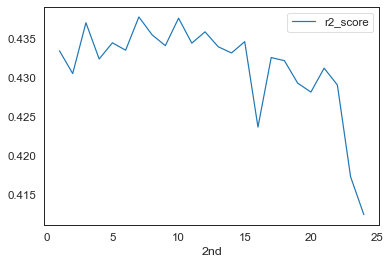

In [818]:
# plot performance change with changing architecture
accuracy_df.plot('2nd','r2_score')

In [373]:
df3

,temp,humidity,radiation,NO,NO2,SO2,PM2.5,PM2.5_Lag1,PM2.5_Lag2,Wx,Wy
time,,,,,,,,,,,
2016-01-01 00:00:00,19.0,70.1,0.500000,0.700000,0.700000,0.5,12.0,9.7,7.7,1.498426,3.708735
2016-01-01 01:00:00,19.0,72.1,0.700000,0.500000,1.100000,0.3,21.0,12.0,9.7,1.143363,3.518909
2016-01-01 02:00:00,19.0,70.2,0.800000,0.700000,0.500000,0.3,17.8,21.0,12.0,1.359675,4.184649
2016-01-01 03:00:00,19.0,70.2,0.700000,5.301098,9.222584,0.4,10.6,17.8,21.0,1.174265,3.614015
2016-01-01 04:00:00,19.0,69.6,1.100000,0.300000,0.400000,0.0,8.9,10.6,17.8,1.269716,3.687522
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,21.0,61.2,297.978237,0.785631,13.772844,0.0,4.1,2.6,4.9,2.080141,-0.716250
2020-12-31 20:00:00,20.0,65.0,239.511438,3.197785,15.206565,0.0,8.4,4.1,2.6,-0.887498,-1.903246
2020-12-31 21:00:00,19.0,67.1,214.147884,2.403539,14.074117,0.0,5.7,8.4,4.1,-1.677341,-1.089278


In [795]:
# Mking data for LSTM
df4 = df3.reset_index()
df5 = df4[['time','PM2.5','PM2.5_Lag1','PM2.5_Lag2','NO','NO2','SO2']]
# Expor data for LSTM
df5.to_csv('test.csv')

In [819]:
'''
Model Comparison
'''
# Run model with first layer of 17 and second layer of 8
# Keep iteration at 112

mlp = MLPRegressor(hidden_layer_sizes=(17,8), max_iter=112, random_state=177).fit(X_train,y_train)
mlp.fit(X_train,y_train)
expected_y = y_test
predicted_y = mlp.predict(X_test)
print(mlp.n_iter_) #Showing the number of iterations the solevr has run to get the accuracies below

expected_yy = scaler.inverse_transform([expected_y])
predicted_yy = scaler.inverse_transform([predicted_y])

a_expectedy = np.asarray(expected_y)
a_predictedy = np.asanyarray(predicted_y)

14


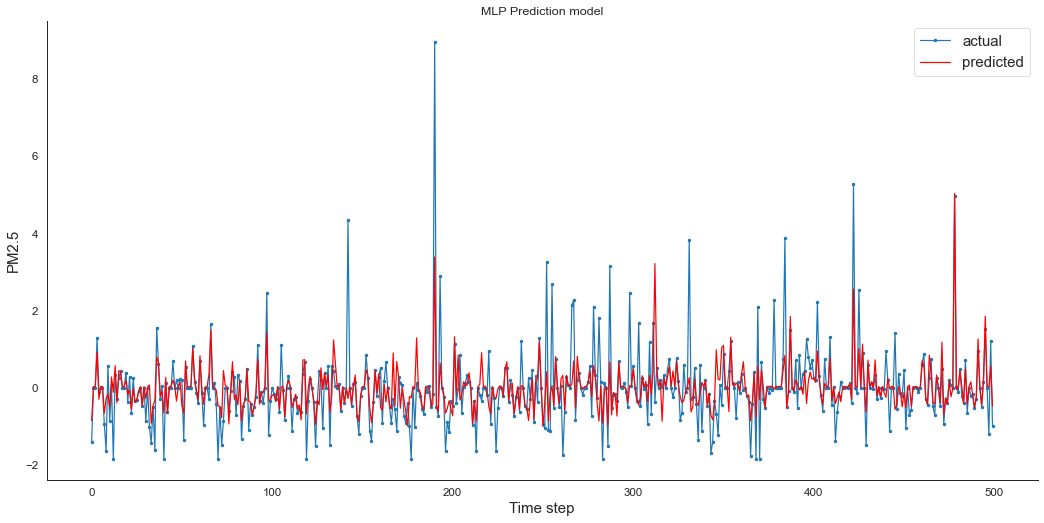

In [822]:
# Plot actual vs predicted
aa=[x for x in range(500)]
plt.figure(figsize=(15,7))
plt.plot(aa, [a_expectedy][0][:500], marker='.', label="actual")
plt.plot(aa, a_predictedy[:,][:500], 'r', label="predicted")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('PM2.5', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.title('MLP Prediction model')
plt.show()